# FTICR-MS Processing and Display of Phase-Sensitive spectra

### *This is a **VERY** preliminary version - use with caution*

a simplified environment for processing 1D Bruker FTICR datasets with `SPIKE`

Run each python cell in sequence by using the ⇥Run button above (or typing *shift* Enter).

Cells are meant to be used in order, taking you to the complete analysis, but you can go back at any time.


### Initialization of the environment
the following cell should be run only once, at the beginning of the processing

## STARTING Environment...


          SPIKE
    Version     : 0.99.21
    Date        : 23-02-2021
    Revision Id : 490
*** zoom3D not loaded ***
plugins loaded:
Fitter,  Linear_prediction,  Peaks,  bcorr,  fastclean,  gaussenh,  rem_ridge,  sane,  sg,  test,  urQRd, 

spike.plugins.report() for a short description of each plugins
spike.plugins.report('module_name') for complete documentation on one plugin
plugins loaded:
FTMS_calib,  PhaseMS,  diagonal_2DMS, 
*** PALMA not loaded ***
plugins loaded:
Bruker_NMR_FT,  Bucketing,  Integrate,  apmin, 

Interactive module version, 1.2.0
Run date: 2021-05-22T15:30:32.130927


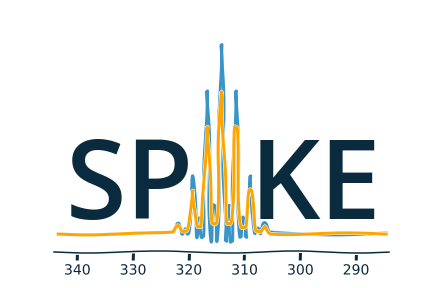

## ...program is Ready

In [1]:
# load all python and interactive tools - should be run only once
from IPython.display import display, HTML, Markdown, Image
display(Markdown('## STARTING Environment...'))
import matplotlib as mpl
%matplotlib widget
import spike
from spike.File import BrukerMS
from spike.Interactive import INTER as I
from spike.Interactive import FTICR_INTER as FI
from spike.Interactive import INTER_MS as IMS
from spike.Interactive.ipyfilechooser import FileChooser
print("\nInteractive module version,",I.__version__)
from datetime import datetime
print('Run date:', datetime.now().isoformat() )
I.initialize()
display(Markdown('## ...program is Ready'))
from importlib import reload  # this line is debugging help

# configurable items
mpl.rcParams['figure.figsize'] = (8,4)   # (X,Y) default figure size
I.Activate_Wheel = True                  # True/False wheel control in the graphic cells 

### Choose the file
Use `FileChooser()` to choose a file on your disk - The optional `base` argument, starts the exploration on a given location.

Bruker files are named `fid` and are contained in a `*.d` directory.

In [2]:
FC = FileChooser(filetype='fid')
display(FC)

FileChooser(path='/home/mad/Documents/spike/Notebooks', filename='', show_hidden='False')

(After the selection, the selected filename is found in the `FC.selected` variable)
### Import dataset


In [3]:
# This is simply done with the `Import_1D()` tool, which returns a `SPIKE` object.
# We store it into a variable, evaluating the variable show a summary of the dataset. 
print('Reading file ',FC.selected)
d1 = BrukerMS.Import_1D(FC.selected)
d1.filename = FC.selected
d1.set_unit('sec').display(title=FC.selected_path+" transient")
d1

Reading file  /DATA/DATA_res/FT-ICR/spectres MS complexes/polyA_ms_000001.d/fid
Using 3 parameters calibration,  Warning calibB is -ML2


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

FTICR data-set
Bo: 9.40
Single Spectrum data-set
FT-ICR axis at 1000.000000 kHz,  524288 real points,  from physical mz =  144.129   to m/z = 1500.000  R max (M=400) = 188997

In the current set-up, the figure can be explored *(zoom, shift, resize, etc)* with the jupyter tools displayed  below the dataset.
The figure can also be saved as a `png` graphic file.

At anytime, the figure can be frozen by clicking on the blue button on the upper right corner, just rerun the cell for changing it.

### Compute Modulus Spectrum

many processing methods are available, they can be either applied one by one, or piped by chaining them.

Here we are chaining  apodisation - zerofill - FT - modulus

then setting to `m/z` unit (`Hz` and `points` also available) - finally `display()` is used to display the dataset.


In [6]:
D1 = d1.copy() # copy the imported data-set to another object for processing
D1.kaiser(4).zf(4).rfft().modulus() # kaiser(4) is an apodisation well adapted to FTICR, slightly more resolution than hamming(
D1.set_unit('m/z').display(title=FC.selected_path)  # set to ppm unit - and display

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

FTICR data-set
Bo: 9.40
Single Spectrum data-set
FT-ICR axis at 1000.000000 kHz,  1048576 real points,  from physical mz =  144.129   to m/z = 1500.000  R max (M=400) = 377995

In [5]:
D1ph = d1.copy() # copy the imported data-set to another object for processing
D1ph.apod_sin(maxi=0.15).zf(1).rfft()
#D1ph.apod_sin(maxi=0.35).rfft()
D1ph.set_unit('m/z').display(title=FC.selected_path)  # set to ppm unit - and display

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

FTICR data-set
Bo: 9.40
Single Spectrum data-set
FT-ICR axis at 1000.000000 kHz,  262144 complex pairs,  from physical mz =  144.129   to m/z = 1500.000  R max (M=400) = 188997

In [7]:
def firstguess(data):
    """
    compute phase initial guess
    """
    import math
    if data.params['SwpDir'] == '0':
        print('Decreasing')
    else:
        print('*** Increasing ***')
    sw = float(data.params['SW_h'])
    f0 = sw
    f1 = float(data.params['FR_low'])
    deltaf = f1-f0
    te = 3E-3
    p3 = float(data.params['P_3'])*1E-6
    l31 = int(data.params['L_31'])
    tau = l31*p3
    ph1 = -tau*f1/sw + te 
    ph2 = tau/sw
    return (math.sqrt(3)*ph1*sw, ph2*sw*sw/2)
print("Pivot:0  P0: 0.00  P1: %.2f  P2: %.2f"%firstguess(d1))

Decreasing
Pivot:0  P0: 0.00  P1: 2909.48  P2: 6860.00


Phaser1D(children=(VBox(children=(HBox(children=(Button(button_style='success', description='Done', style=Butt…

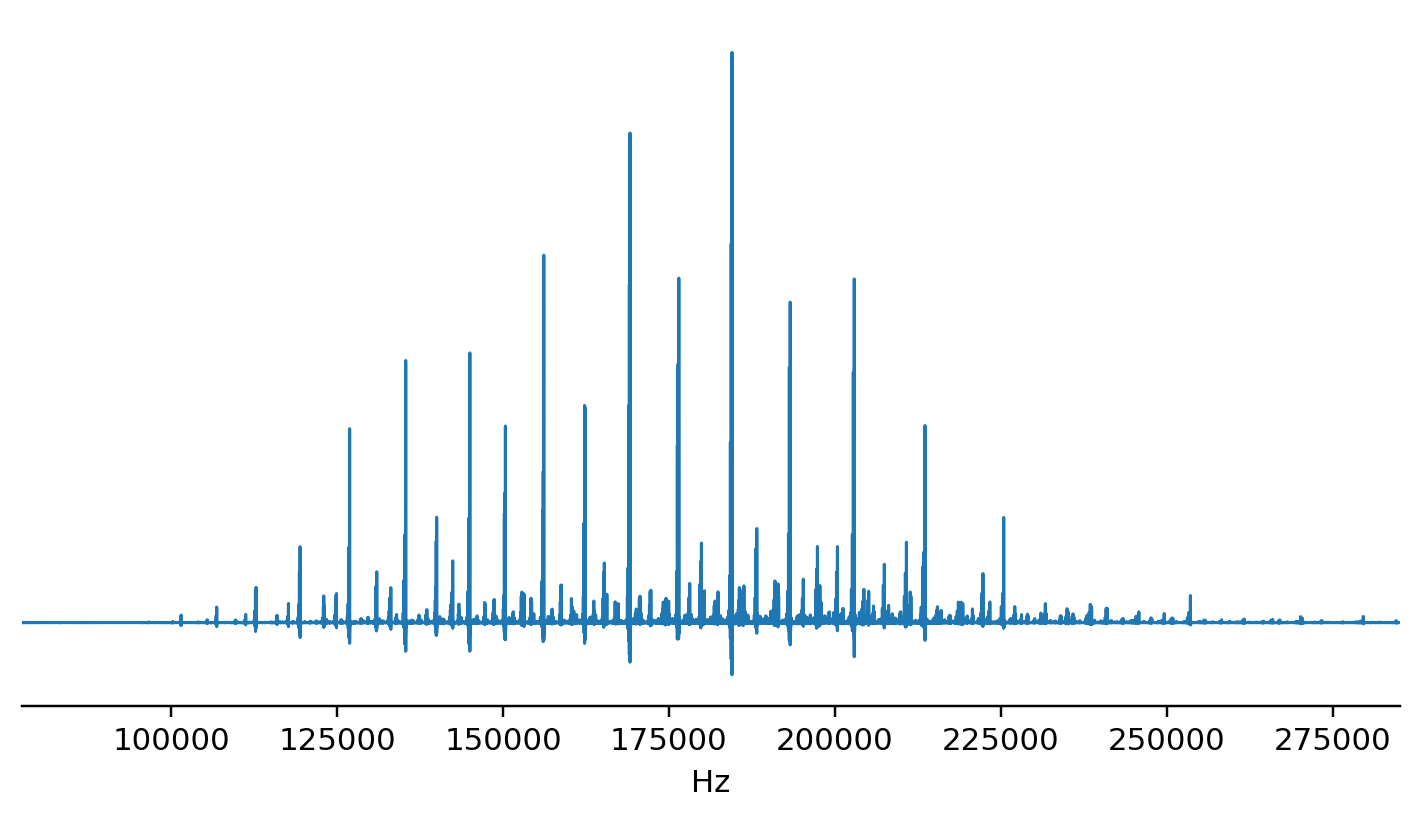

Applied: phaseMS(-170.0,  -1573.0, 16012.0, 0.00)


In [8]:
reload(IMS)
IMS.Phaser1D(D1ph.set_unit('Hz'));

In [9]:
D1ph.set_unit('m/z').display(title=FC.selected_path)  # set to ppm unit - and display

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

FTICR data-set
Bo: 9.40
Single Spectrum data-set
FT-ICR axis at 1000.000000 kHz,  262144 complex pairs,  from physical mz =  144.129   to m/z = 1500.000  R max (M=400) = 188997

In [10]:
D1ph.set_unit('m/z').display(title=FC.selected_path)  # set to ppm unit - and display

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

FTICR data-set
Bo: 9.40
Single Spectrum data-set
FT-ICR axis at 1000.000000 kHz,  262144 complex pairs,  from physical mz =  144.129   to m/z = 1500.000  R max (M=400) = 188997

In [7]:
result=[
("/DATA/DATA_res/FT-ICR/APOAI_H2OMetOHAF_MS_profile_000001.d/fid", (46.27, -253, 416), (-4830.365981876569, 2742.7936467346176)),
("/DATA/DATA_res/FT-ICR/APOAI_H2OMetOHAF_MS_profile_000001_CAL.d/fid", (71, 390, 891), (-4830.365981876569, 2742.7936467346176)),
("/DATA/DATA_res/FT-ICR/NG_Boeuf_000001.d/fid", (76, -857,711), (-639.5090074430963, 599.9949641828464)),
("/DATA/DATA_res/FT-ICR/manipes en phases/manip0-0-0 0-90-0/insuline_ms_000001.d/fid", (-176.7,  -786.2, 4004.0, 0.00), (593, 4008)),
('/DATA/DATA_res/FT-ICR/manips pour correction de phase/angio_ms2_000062.d',(-61.4,  -1537.3, 15936.4, 0.00), (-140.73738007869642, 16010.627382136738)),
('/DATA/DATA_res/FT-ICR/manips pour correction de phase/angio_ms_000005.d',(108.2,  -1694.9, 16162.3, 0.00),(-140.73738007869642, 16010.627382136738)),
('/DATA/DATA_res/FT-ICR/spectres MS complexes/polyA_ms_000001.d',(26.4,  -1568.4, 16001.6, 0.00), (2666.016690356435, 7590.387273079339))
]

In [23]:
def firstguess0(data):
    """
    as firstguess but for old Bruker systems (with acqus file)
    """
    import math
    acqu = data.params['acqu']
    sw = float(acqu['$SW_h'])
    f0 = sw
    f1 = float(acqu['$FR_low'])
    deltaf = f1-f0
    te = 3E-3
    p3 = float(acqu['$P'][3])*1E-6
    l31 = int(acqu['$L'][31])
    tau = l31*p3
    ph1 = tau*f1/deltaf + te 
    ph2 = -tau/deltaf
    return (ph1*sw, ph2*sw*sw/2)
firstguess0(D1ph)

(682.0853471567385, 117.49391178748401)

### Save processed data
You can save a dataset, two formats are available:

- Native SPIKE format, `*.msh5` where all informations are stored - run the following cell

- Or `cvs` format, with only the spectrum (for the peak list, see above) - ( *be carefull this file can be very big*)

### superimpose spectra
you can superimpose several spectra stored as `.msh5` files in order to compare them

*the following cell display the colormap used here*